We have implemented the control variates variance reduction method in the file `controlvariates.py`. In this notebook, we illustrate it on the calculation of an indicator from the discrete event simulator. You may want to have a look at the implementation first.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from discrete_events import DiscreteEventSimulator
from controlvariates import controlvariates

The function `collect_draws`collects the average time spent in the system by the customers of the discrete event simulator (`average_time`). The control variable is the average service time (`service_time`). The function `simulate`runs the simulator `R` times, and returns both the regular estimate of the average time, and the control variate estimate.  

Note that, from the point of view of the control variate algorithm, we consider each run of the simulator as one draw. The simulator is a black box, and we do not use the draws generated inside the simulator itself. 

In [2]:
def mean(array):
    if array.size == 0:
        return 0
    return np.mean(array)

In [3]:
def simulate(R, serv_time):
    def collect_draws():
        des_1 = DiscreteEventSimulator(
            arrival_rate=1,
            service_time=serv_time,
            red_time=None,
            green_time=None,
            closure_time=10
        )
        des_1.run()
        average_time = mean(
            np.array(
                [
                    des_1.departures[k] - des_1.arrivals[k] 
                    for k in des_1.arrivals.keys()
                ]
            )
        )
        service_time = mean(
            np.array(des_1.draws_service_time)
        )
        return average_time, service_time
    all_results = [collect_draws() for r in range(R)]
    total_time, service_time =  zip(*all_results)
    return (
        np.mean(total_time), 
        controlvariates(total_time, service_time, serv_time)
    )

In [4]:
the_service_time = 0.2
R = 1000
all_r = range(10, R)
estimates = [simulate(r, serv_time=the_service_time) for r in tqdm(all_r)]

100%|██████████| 990/990 [01:07<00:00, 14.57it/s]


In [5]:
independent, controlled = zip(*estimates)

The plot below shows the estimate of the indicator as a function of the number of replications, for the two estimation methods. The variance reduction obtained from the control variate algorithm is clearly illustrated. Note that if you increase the service time, it will generate queues, and the quality of the variance reduction with reduce. Try it.

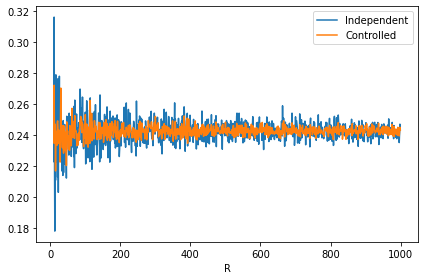

In [6]:
plt.plot(all_r, independent, label='Independent')
plt.plot(all_r, controlled, label='Controlled')
plt.xlabel('R')
plt.tight_layout()
plt.legend()
plt.show()